# Imports

In [ ]:
import pandas as pd
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
import os
import cv2
from pathlib import Path

from PIL import Image
import glob

# Preparar los datasets

In [9]:
df_ = pd.read_csv('train_RSNA.csv')
df = df_.dropna(subset=['density'])
print(df.shape)
df.head(1)

(29470, 14)


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
12,1,10038,1967300488,L,MLO,60.0,0,0,0,1.0,0,C,216,False


In [10]:
df.describe()

,site_id,patient_id,image_id,age,cancer,biopsy,invasive,BIRADS,implant,machine_id
count,29470.0,29470.000000,2.947000e+04,29433.000000,29470.000000,29470.000000,29470.000000,23676.000000,29470.000000,29470.000000
mean,1.0,32720.484595,1.079334e+09,57.346686,0.022531,0.079844,0.015270,0.855677,0.049542,73.113268
std,0.0,18827.481129,6.190319e+08,11.341098,0.148406,0.271056,0.122626,0.560278,0.217000,53.527467
min,1.0,25.000000,6.849100e+04,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,49.000000
25%,1.0,16785.000000,5.423273e+08,48.000000,0.000000,0.000000,0.000000,1.000000,0.000000,49.000000
50%,1.0,32362.000000,1.084091e+09,57.000000,0.000000,0.000000,0.000000,1.000000,0.000000,49.000000
75%,1.0,48917.000000,1.610664e+09,66.000000,0.000000,0.000000,0.000000,1.000000,0.000000,49.000000
max,1.0,65534.000000,2.147472e+09,89.000000,1.000000,1.000000,1.000000,2.000000,1.000000,216.000000


In [11]:
df49 = df.loc[(df['machine_id'] == 49) & (df['implant'] == 0)]
df49.shape


(22148, 14)

# Analisis de datos


In [ ]:
x, y = df_.shape
print(f"El dataset tiene {x} filas y {y} columnas")
print(f"Que tengan un valor en la columna density solo {df.shape[0]} filas")

El dataset tiene 54706 filas y 14 columnas
Que tengan un valor en la columna density solo 29470 filas


## Observación de las imagenes por máquina

In [ ]:
# Existen diferentes maquinas. Vamos a mostrar una imagen de cada maquina
df['machine_id'].value_counts()

,count
machine_id,
49,23488
93,1915
216,1908
210,1070
170,915
190,145
197,29


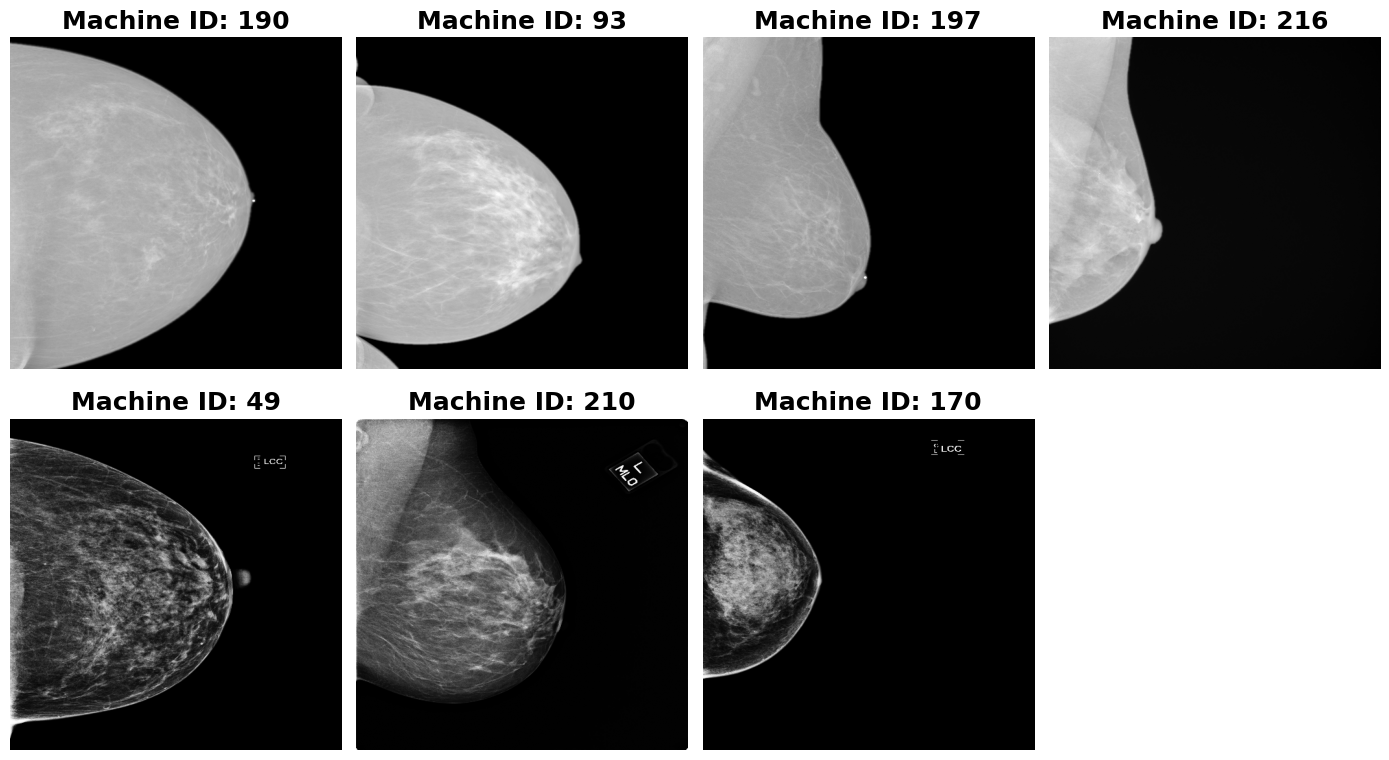

In [ ]:
# Obtener un patient_id y un image_id por cada machine_id
machine_patient_sample = df.groupby('machine_id')['patient_id'].first().reset_index()

d = {190: 1, 93: 2, 197: 3, 216: 4, 49: 5, 210: 6, 170: 7}

plt.figure(figsize=(14, 8))

# Mostrar una imagen para cada patient_id seleccionado
for index, row in machine_patient_sample.iterrows():
    machine_id = row['machine_id']
    patient_id_sample = row['patient_id']

    # Obtener una imagen_id para ese patient_id (tomamos la primera disponible)
    image_row = df[(df['patient_id'] == patient_id_sample) & (df['machine_id'] == machine_id)].iloc[0]
    image_id_sample = image_row['image_id']

    filename = f"{int(patient_id_sample)}_{int(image_id_sample)}.png"
    img_path = Path("RSNA") / filename

    if img_path.exists():
        plt.subplot(2, 4, d[machine_id])
        plt.imshow(imread(img_path), cmap='gray')
        plt.title(f"Machine ID: {machine_id}", fontdict={'fontsize': 18, 'weight': 'bold'})
        plt.axis('off')
    else:
        print(f"Imagen no encontrada para Machine ID: {machine_id}, Patient ID: {patient_id_sample}, Filename: {filename}")

plt.tight_layout()
plt.show()

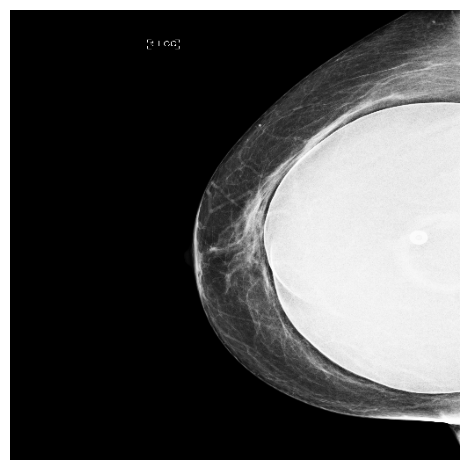

In [ ]:
# Existen mamografias con implantes
plt.imshow(imread("RSNA/10960_372686829.png"), cmap='gray')
plt.axis('off')
plt.tight_layout()

In [ ]:
# Las quitamos y nos quedamos con:
df49 = df49.loc[df49['implant'] == 0]
df49.shape

(22148, 14)

## Histograma medio

In [12]:
TITULOS = None
SUBTITULOS = {'fontsize': 14}

def calcular_histograma_medio(df, bins=256, in_dir='RSNA/'):
    acumulador = np.zeros(bins, dtype=np.float64)
    total_imagenes = 0

    for _, row in df.iterrows():
        path = f"{int(row['patient_id'])}_{int(row['image_id'])}.png"
        path = in_dir + path

        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue  # Imagen no cargada
        hist = cv2.calcHist([img], [0], None, [bins], [0, 256])
        hist = hist.flatten()
        acumulador += hist
        total_imagenes += 1

    if total_imagenes == 0:
        raise ValueError("No se pudo procesar ninguna imagen.")

    histograma_medio = acumulador / total_imagenes
    return histograma_medio

In [17]:
bottom_imgs = [49, 210, 170] # Estas son las máquinas presentes en la fila de abajo
hist_medio_fila_abajo = calcular_histograma_medio(df.loc[df['machine_id'].isin(bottom_imgs)], bins=256)
hist_medio_fila_arriba = calcular_histograma_medio(df.loc[~df['machine_id'].isin(bottom_imgs)], bins=256)

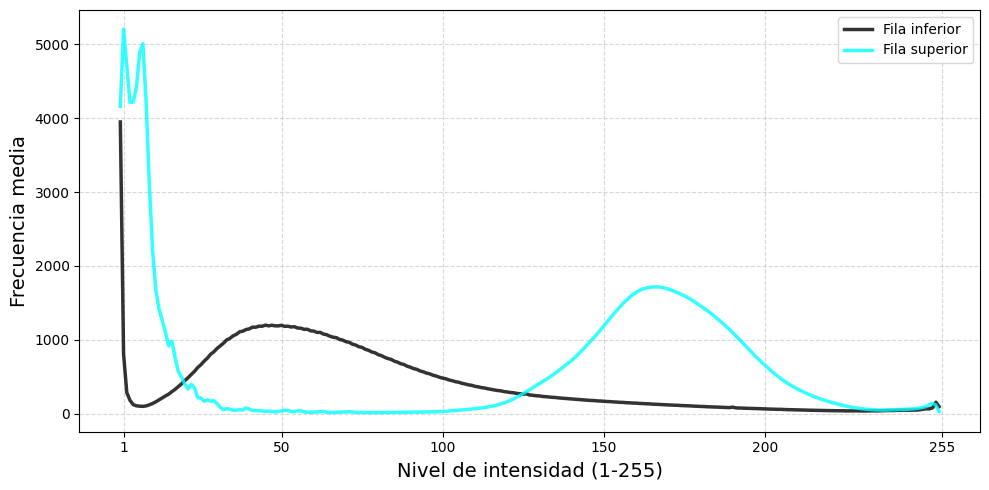

In [18]:
plt.figure(figsize=(10, 5))
line1 = plt.plot(hist_medio_fila_abajo[1:], color='black', alpha = 0.8, linewidth=2.5)
plt.xlabel("Nivel de intensidad (1-255)", fontdict=SUBTITULOS)
plt.ylabel("Frecuencia media", fontdict=SUBTITULOS)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

line2 = plt.plot(hist_medio_fila_arriba[1:], color='cyan', alpha=0.8, linewidth=2.5)
plt.xlabel("Nivel de intensidad (1-255)", fontdict=SUBTITULOS)
plt.ylabel("Frecuencia media", fontdict=SUBTITULOS)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks([1, 50, 100, 150, 200, 255])
plt.tight_layout()

plt.legend(["Fila inferior", "Fila superior"])
plt.show()

# Machine IDs

<ipython-input-94-66b7fb2bbc27>:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(counts.index)


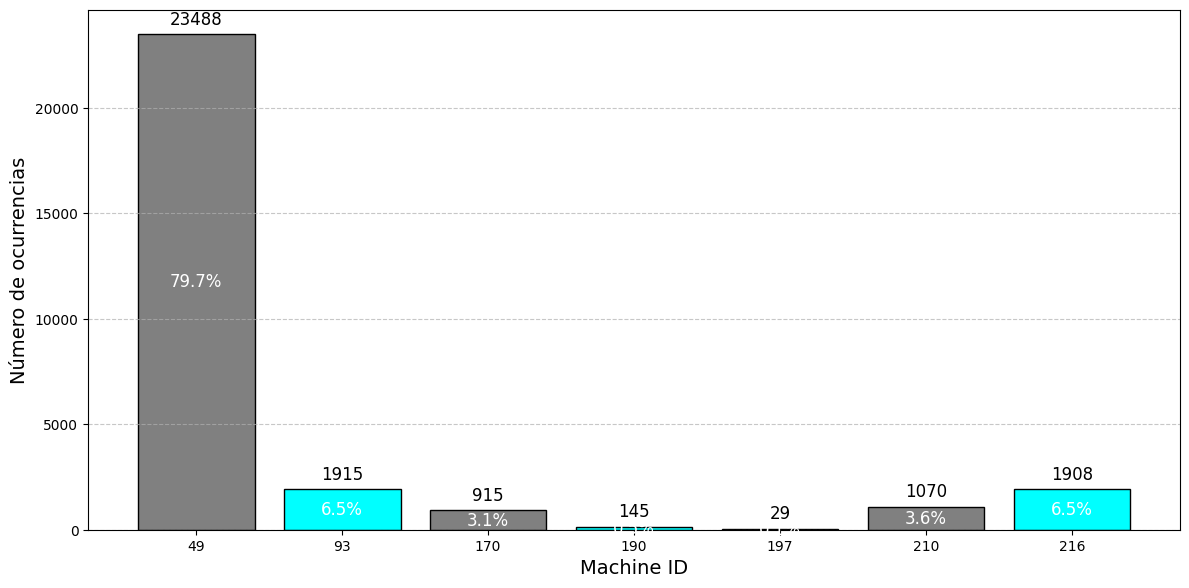

In [ ]:
counts = df['machine_id'].value_counts().sort_index()
total = counts.sum()
porcentajes = (counts / total) * 100

# Paso 2: Diccionario de colores 
color_dict = {
    True: 'gray',
    False: 'cyan'
}

# Paso 3: Gráfico de barras
fig, ax = plt.subplots(figsize=(12, 6))
machine_ids = counts.index.tolist()
bar_colors = [color_dict.get(mid in bottom_imgs, 'gray') for mid in machine_ids]
bars = ax.bar([str(i) for i in machine_ids], counts.values, color=bar_colors, edgecolor='black')

# Paso 4: Añadir etiquetas
for bar, count, pct in zip(bars, counts.values, porcentajes.values):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    ax.text(x, y + total * 0.01, f"{count}", ha='center', va='bottom', fontsize=12)           # Cantidad arriba
    ax.text(x, y * 0.5, f"{pct:.1f}%", ha='center', va='center', fontsize=12, color='white')  # Porcentaje dentro

# Estética
ax.set_xlabel("Machine ID", fontdict=SUBTITULOS)
ax.set_ylabel("Número de ocurrencias", fontdict=SUBTITULOS)
ax.set_xticklabels(counts.index)
ax.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Distribución de la densidad mamaria

<ipython-input-52-2c8ad6956350>:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(counts.index)


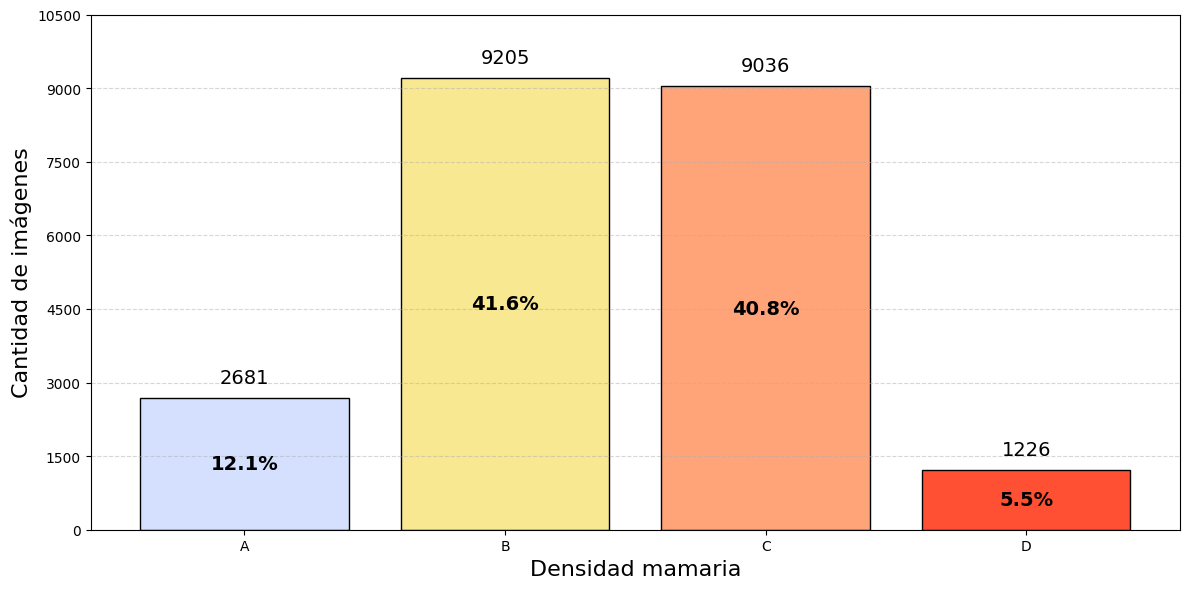

In [ ]:
counts = df49['density'].value_counts().sort_index()
total = counts.sum()
porcentajes = (counts / total) * 100

# Paso 2: Diccionario de colores (puedes personalizarlo)
color_dict = {
    True: 'gray',
    False: 'cyan'
}

# Paso 3: Gráfico de barras
fig, ax = plt.subplots(figsize=(12, 6))
machine_ids = counts.index.tolist()
bars = ax.bar([str(i) for i in machine_ids], counts.values, color=bar_colors, edgecolor='black')

# Paso 4: Añadir etiquetas
for bar, count, pct in zip(bars, counts.values, porcentajes.values):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    ax.text(x, y + total * 0.01, f"{count}", ha='center', va='bottom', fontsize=14)           # Cantidad arriba
    ax.text(x, y * 0.5, f"{pct:.1f}%", ha='center', va='center', fontsize=14, color='black', fontweight='bold')  # Porcentaje dentro

# Estética
ax.set_xlabel("Densidad mamaria", fontdict=SUBTITULOS)
ax.set_ylabel("Cantidad de imágenes", fontdict=SUBTITULOS)
ax.set_xticklabels(counts.index)
ax.set_yticks(range(0, 11000, 1500))
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
